In [84]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sns
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [85]:
case_total = pd.read_csv('budget.csv')

In [86]:
case_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0    2018_cases_rates        152 non-null    float64
 1   total_budget_capita      152 non-null    float64
 2   clean_air_percap         152 non-null    float64
 3   clean_environ_percap     152 non-null    float64
 4   health_training_percap   152 non-null    float64
 5   school_awareness_percap  152 non-null    float64
 6   media_awareness_percap   152 non-null    float64
 7   sub_counselling_percap   152 non-null    float64
dtypes: float64(8)
memory usage: 9.6 KB


In [87]:
case_total.head()
#case_total_noarea=case_total.drop('local_authority_area', inplace=True, axis=1)
#case_total_noarea=case_total.drop('2018_cases_total', inplace=True, axis=1)
#case_total.drop('2018_pop_total')

,2018_cases_rates,total_budget_capita,clean_air_percap,clean_environ_percap,health_training_percap,school_awareness_percap,media_awareness_percap,sub_counselling_percap
0,0.0045,0.7232,0.3100,0.1840,0.0270,0.0920,0.0500,0.0610
1,0.0050,0.6886,0.1860,0.1330,0.0450,0.1590,0.0930,0.0720
2,0.0035,0.7855,0.2050,0.3100,0.0460,0.1110,0.0490,0.0650
3,0.0036,0.6307,0.1680,0.0380,0.0920,0.1910,0.0360,0.1060
4,0.0030,0.6018,0.1430,0.0750,0.0550,0.1850,0.0940,0.0490


In [88]:
#case_total_numeric = pd.get_dummies(case_total)

In [89]:
#case_total_numeric.head()

In [90]:
#case_total_numeric.head()

Text(0.5, 1.0, 'Correlation Matrix')

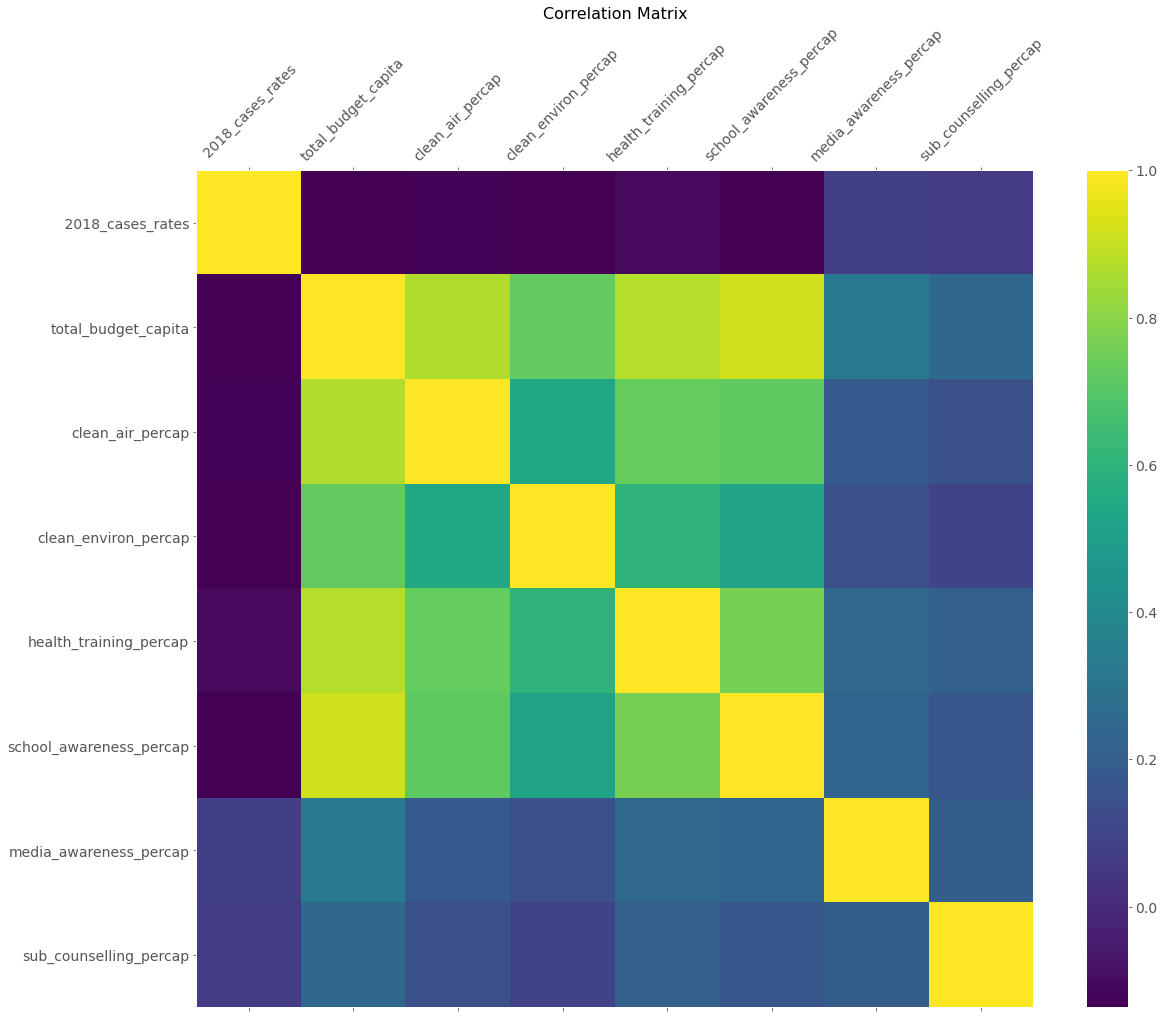

In [91]:
df = case_total
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

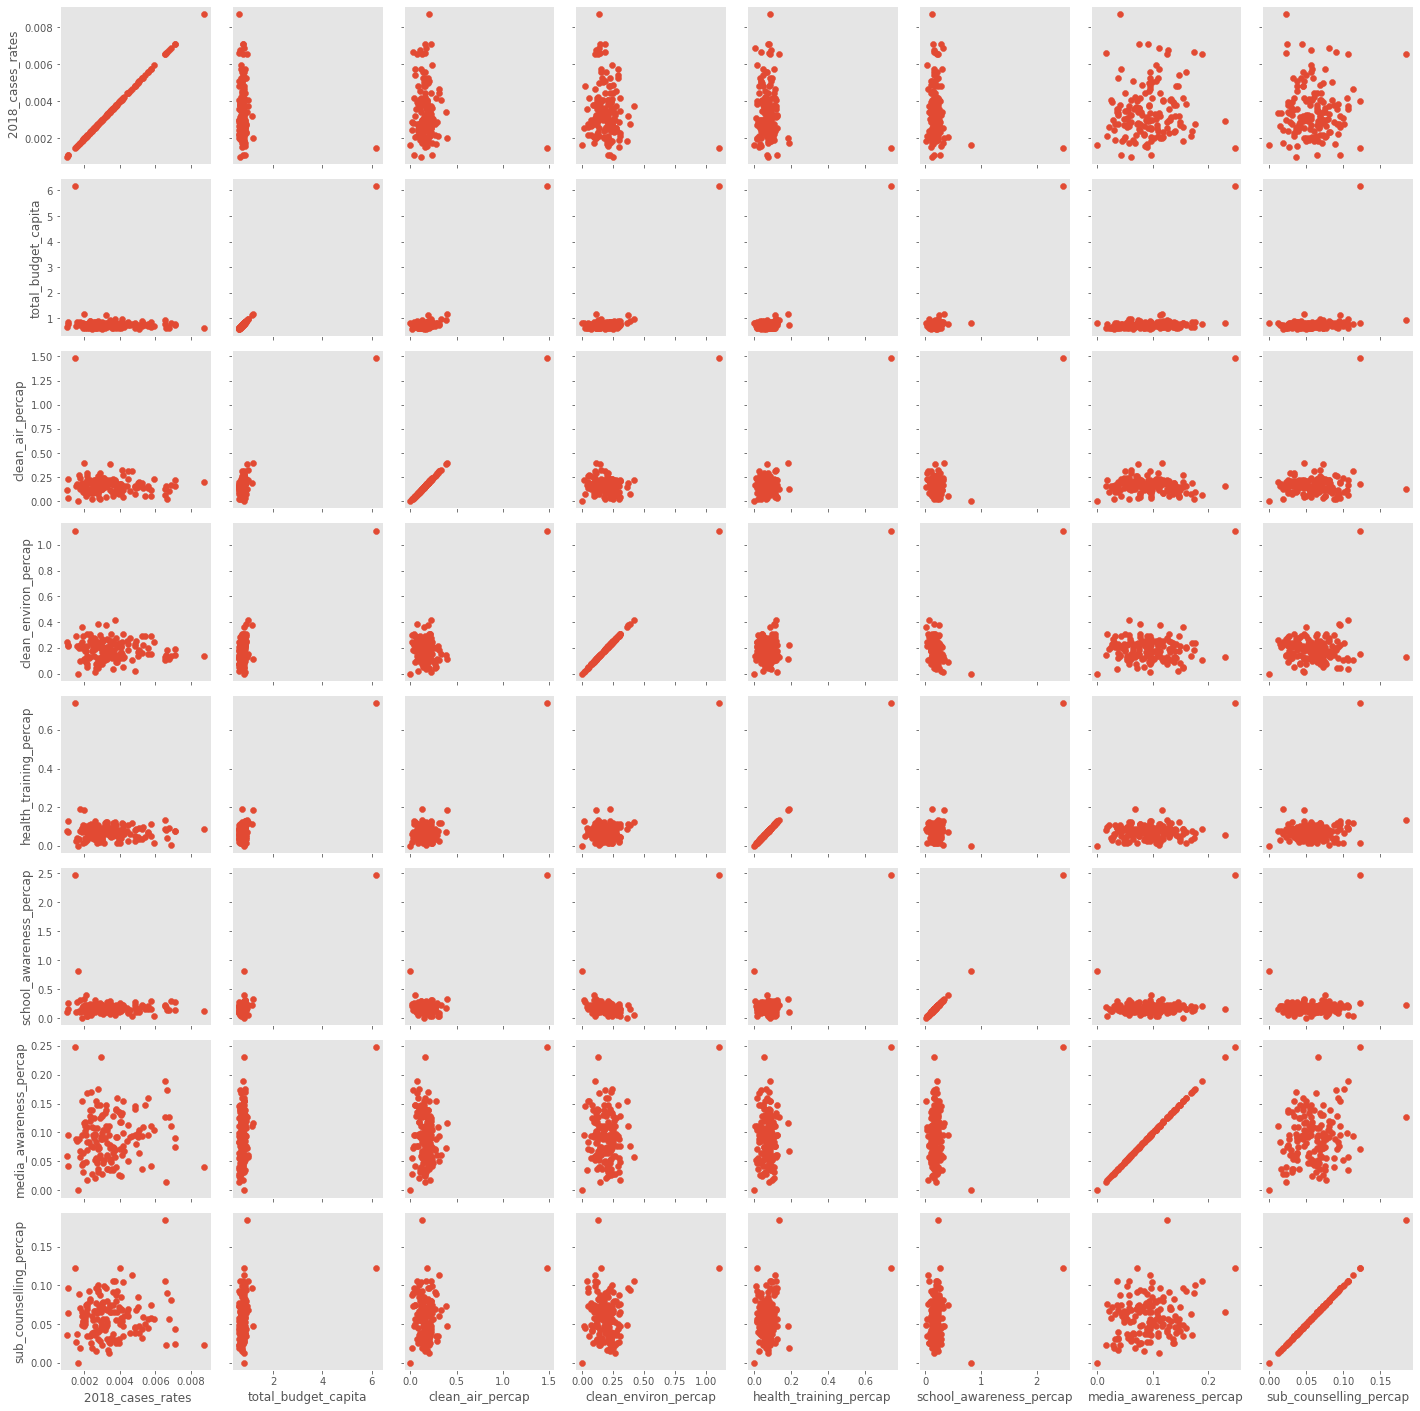

In [92]:
g=sns.PairGrid(case_total)
g.map(plt.scatter)

In [81]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [82]:
case_total_new = drop_column_using_vif_(case_total.drop(' 2018_cases_rates', axis=1))
case_total_new
print(case_total_new.columns)

Dropping: total_budget_capita
Index(['clean_air_percap', 'clean_environ_percap', 'health_training_percap',
       'school_awareness_percap', 'media_awareness_percap'],
      dtype='object')


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [83]:
case_total_vif = sm.OLS(endog=case_total[[' 2018_cases_rates']], exog=case_total_new).fit()
case_total_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       2018_cases_rates   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.752
Method:                 Least Squares   F-statistic:                              93.12
Date:                Sat, 13 Nov 2021   Prob (F-statistic):                    8.92e-44
Time:                        14:42:55   Log-Likelihood:                          743.35
No. Observations:                 152   AIC:                                     -1477.
Df Residuals:                     147   BIC:                                     -1462.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
clean_air_percap            0.0023      0.002      1.262      0.209      -0.001       0.006
clean_environ_percap        0.0053      0.002      3.296      0.001       0.002       0.008
health_training_percap     -0.0024      0.004     -0.567      0.572      -0.011       0.006
school_awareness_percap    -0.0020      0.001     -1.614      0.109      -0.004       0.000
media_awareness_percap      0.0236      0.003      8.757      0.000       0.018       0.029
==============================================================================
Omnibus:                       13.739   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               41.795
Skew:                           0.077   Prob(JB):                     8.40e-10
Kurtosis:                       5.564   Cond. No.                         11.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TypeError: 'RegressionResultsWrapper' object is not iterable